<a href="https://colab.research.google.com/github/gauthiermartin/pytorch-deep-learning-course/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets

We've used some datasets with PyTorch before.

But how to get your own data into PyTorch

One of the ways to do so is via : custom datasets.

## Domain libraries

Depending on what you're worjing on (vision, text, audio, ...) look for existing dataloader in each of those domain libraries to base your implementation on it

**Resources:**
* Book version of the course material for chapter 6 - https://www.learnpytorch.io/04_pytorch_custom_datasets/

* Ground truth version of the notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb


In [1]:
import torch
from torch import nn

device = "gpu"if torch.cuda.is_available() else "cpu"

In [2]:
device

'gpu'

In [3]:
!nvidia-smi

Mon Aug 28 11:02:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Get Data

Our dataset is a subset of the food101 dataset, which starts with 101 classes ours will starte with only 3 classes of food and 10% of images per classes (~ 75 training, 25 testing)

Why are we doing this ?  

When starting out ML Projects, it's important to try thing from a small subset of data to speed up experiments

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exist, skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak and sushi data")
    f.write(request.content)

  # Unzip
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak sushi data")
    zip_ref.extractall(image_path)



data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak sushi data


 ## 2. Becoming one with the data (data preparation and data exploration)


In [5]:
import os

def walk_through_dir(dir_path):
  """Walks through dir path returning it's contents."""

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path  / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to
1. Get all of the image paths
2. Pick a random image using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with Python PIL
5. Show the image an print metadata

Random image path:data/pizza_steak_sushi/test/pizza/1687143.jpg
Image class:pizza
Image height: 512
Image width: 512


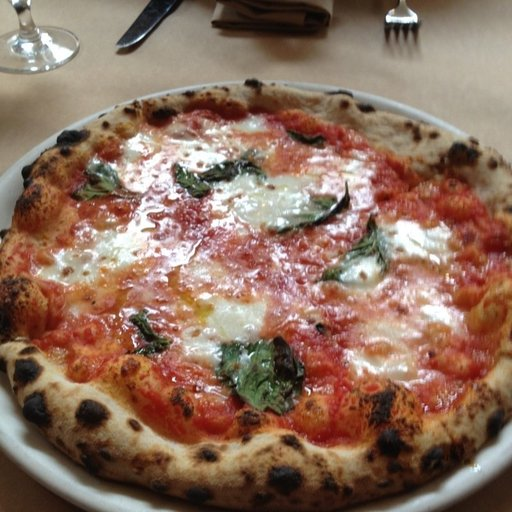

In [23]:
import random
from PIL import Image

# set seed
random.seed(42)

# 1. Get all the images paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class from the path name (the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open up the image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path:{random_image_path}")
print(f"Image class:{image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

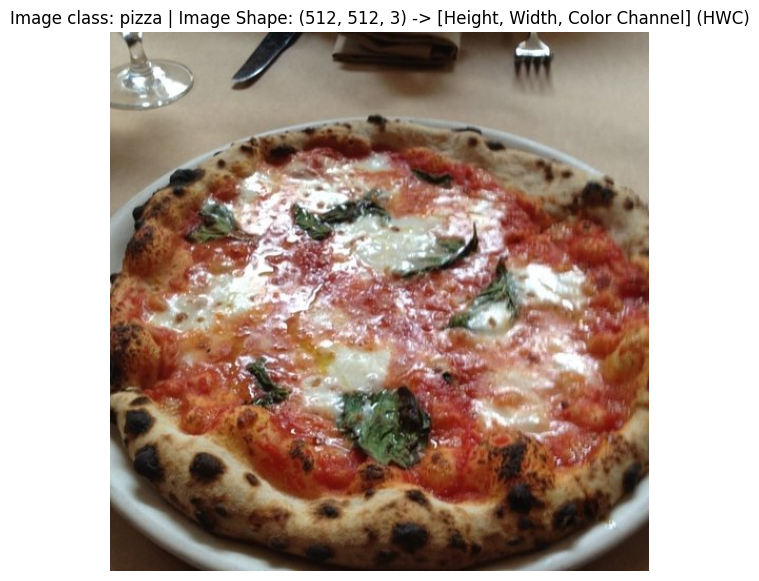

In [27]:
import numpy as np
import matplotlib.pyplot as plt

img_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_array)
plt.title(f"Image class: {image_class} | Image Shape: {img_array.shape} -> [Height, Width, Color Channel] (HWC)")
plt.axis(False)


In [28]:
img_array

array([[[173, 172, 151],
        [176, 175, 154],
        [179, 177, 154],
        ...,
        [141, 133, 114],
        [142, 134, 115],
        [143, 135, 116]],

       [[173, 172, 151],
        [177, 176, 155],
        [180, 178, 155],
        ...,
        [143, 135, 116],
        [143, 135, 116],
        [143, 135, 116]],

       [[175, 174, 153],
        [177, 176, 155],
        [181, 179, 158],
        ...,
        [144, 135, 118],
        [144, 135, 118],
        [144, 135, 118]],

       ...,

       [[ 80,  54,  37],
        [ 78,  52,  35],
        [ 76,  50,  33],
        ...,
        [ 65,  44,  27],
        [ 68,  47,  30],
        [ 70,  49,  32]],

       [[ 82,  56,  39],
        [ 80,  54,  37],
        [ 79,  53,  36],
        ...,
        [ 68,  47,  30],
        [ 70,  49,  30],
        [ 72,  51,  32]],

       [[ 85,  59,  42],
        [ 84,  58,  41],
        [ 83,  57,  40],
        ...,
        [ 70,  49,  32],
        [ 72,  51,  32],
        [ 74,  53,  34]]

## 3. Transforming Data

Before we can use our image data with PyTorch :
1. Turn target data into tensors (in our case, numerical representation of our images)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`



In [30]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


### 3.1 Transforming data with `torchvision.transforms`

* Transforms help you get your images ready to be used with a model/perform data augmentation

In [32]:
# Write a transform for image

data_transform = transforms.Compose([
  # Resize ou image to 64X64
  transforms.Resize(size=(64,64)),
  # Flip the images randomly on the Horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn image into a torch.Tensor
  transforms.ToTensor()
])

In [36]:
data_transform(img).shape

torch.Size([3, 64, 64])

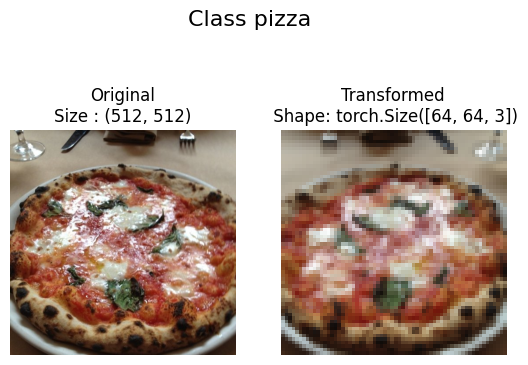

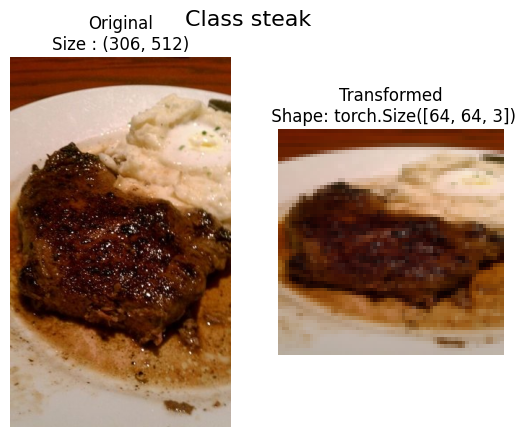

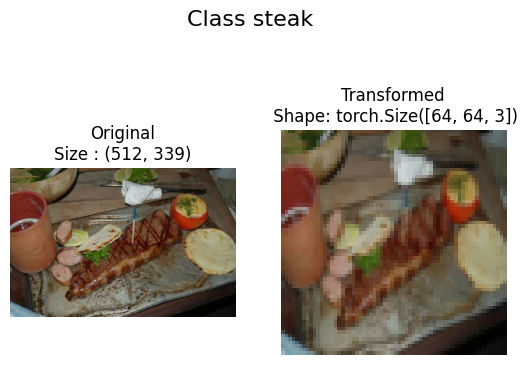

In [45]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
  Selects random images from paths of images and loads/transforms them
  then plots the original vs transformed version.
  """

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize : {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # C, H, W => H,W,C
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\n Shape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                       transform=data_transform,
                       n=3,
                       seed=42)